In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os
from tensorflow.keras import layers
import tensorflow.keras.callbacks as callbacks
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preproces
sing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob
import cv2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Organizing data directories into train, test and valid
train_path = 'Dataset/new dataset/train'
test_path = 'Dataset/new dataset/test'
valid_path = 'Dataset/new dataset/validation'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['0','1','2','3'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['0','1','2','3'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['0','1','2','3'], batch_size=10, shuffle=False)

Found 3389 images belonging to 4 classes.
Found 817 images belonging to 4 classes.
Found 1216 images belonging to 4 classes.


In [5]:
assert train_batches.n==3389   
assert valid_batches.n==817   
assert test_batches.n== 1216 
assert train_batches.num_classes==valid_batches.num_classes==test_batches.num_classes==4

In [6]:
img_array = cv2.imread('Dataset/new dataset/train/2/23882.png')

In [7]:
img_array.shape

(48, 48, 3)

In [9]:
print(img_array)

[[[  4   4   4]
  [ 83  83  83]
  [110 110 110]
  ...
  [  2   2   2]
  [  0   0   0]
  [  0   0   0]]

 [[ 17  17  17]
  [ 64  64  64]
  [102 102 102]
  ...
  [  4   4   4]
  [  2   2   2]
  [  0   0   0]]

 [[ 36  36  36]
  [ 61  61  61]
  [113 113 113]
  ...
  [  8   8   8]
  [  5   5   5]
  [  1   1   1]]

 ...

 [[ 12  12  12]
  [ 10  10  10]
  [  7   7   7]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 12  12  12]
  [ 10  10  10]
  [  7   7   7]
  ...
  [  0   0   0]
  [  1   1   1]
  [  3   3   3]]

 [[ 11  11  11]
  [  8   8   8]
  [  6   6   6]
  ...
  [  4   4   4]
  [  9   9   9]
  [ 18  18  18]]]


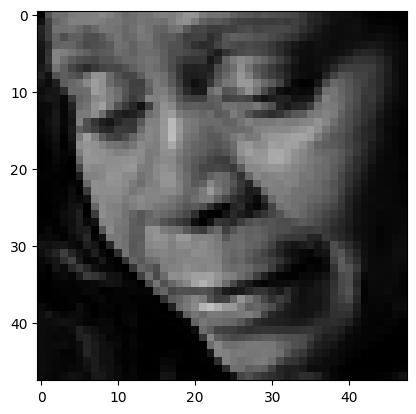

In [10]:
plt.imshow(img_array)

In [11]:
DataDirectory = 'Dataset/new dataset/train/'
classes=['0','1','2','3']

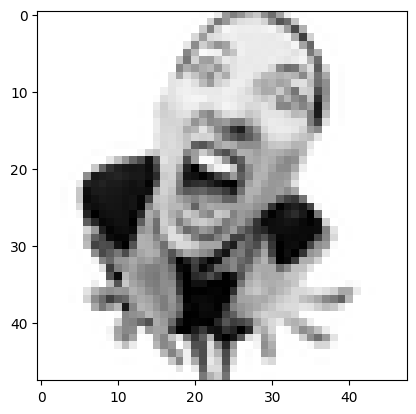

In [12]:
for category in classes:
    path = os.path.join(DataDirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

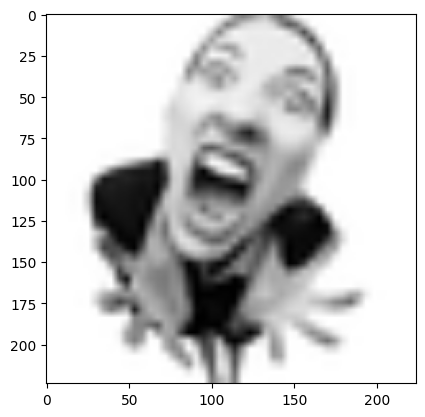

In [13]:
IMAGE_SIZE = 224
new_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
new_array.shape

(224, 224, 3)

In [15]:
# Read all the images and convert them to an array
training_data = []
def create_training_data():
    for category in classes:
        path = os.path.join(DataDirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

In [16]:
create_training_data()

In [17]:
print(len(training_data))

3389


In [18]:
random.shuffle(training_data)

In [19]:
X = [] # features
y = [] # labels
for features, labels in training_data:
    X.append(features)
    y.append(labels)
X = np.array(X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
Y = np.array(y)

In [20]:
X.shape

(3389, 224, 224, 3)

In [21]:
Y.shape

(3389,)

In [22]:
# Normalize data
X = X/255.0;

TRANSFER LEARNING

In [23]:
model = tf.keras.applications.MobileNetV2() # Pre trained model

In [24]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

Transfer Learning - Tuning, weights will start from last check point

In [25]:
base_input = model.layers[0].input

In [26]:
base_output = model.layers[-2].output

In [27]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [98]:
final_output = layers.Dense(128)(base_output) # adding new layer after the output of global pooling layer
final_output = layers.Activation('relu')(final_output) # activation function
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(4,activation='softmax')(final_output) # my classes are 4 --> classification layer (that's why I used softmax)

In [99]:
final_output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_5')>

In [100]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [101]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

                                                                                                  
 block_2_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_2_expand_BN[0][0]']   
                                                                                                  
 block_2_depthwise (Depthwi  (None, 56, 56, 144)          1296      ['block_2_expand_relu[0][0]'] 
 seConv2D)                                                                                        
                                                                                                  
 block_2_depthwise_BN (Batc  (None, 56, 56, 144)          576       ['block_2_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_2_depthwise_relu (Re  (None, 56, 56, 144)          0         ['block_2_depthwise_BN[0][0]']
 LU)      

In [102]:
new_model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

In [103]:
elst=callbacks.EarlyStopping(patience=5, mode='min')
save_ck = callbacks.ModelCheckpoint('new.hdf5', save_best_only=True, mode='min')

In [104]:
new_model.fit(X,Y,epochs=25)

Epoch 1/25
106/106 [==============================] - 330s 3s/step - loss: 0.1992 - accuracy: 0.9398
Epoch 2/25
106/106 [==============================] - 314s 3s/step - loss: 0.1210 - accuracy: 0.9628
Epoch 3/25
106/106 [==============================] - 296s 3s/step - loss: 0.1273 - accuracy: 0.9590
Epoch 4/25
106/106 [==============================] - 1526s 15s/step - loss: 0.1046 - accuracy: 0.9672
Epoch 5/25
106/106 [==============================] - 343s 3s/step - loss: 0.1470 - accuracy: 0.9507
Epoch 6/25
106/106 [==============================] - 333s 3s/step - loss: 0.0971 - accuracy: 0.9690
Epoch 7/25
106/106 [==============================] - 320s 3s/step - loss: 0.0620 - accuracy: 0.9799
Epoch 8/25
106/106 [==============================] - 316s 3s/step - loss: 0.1121 - accuracy: 0.9628
Epoch 9/25
106/106 [==============================] - 326s 3s/step - loss: 0.0864 - accuracy: 0.9714
Epoch 10/25
106/106 [==============================] - 315s 3s/step - loss: 0.0840 - accu

In [105]:
new_model.save('my_model.h5')

In [106]:
new_model = tf.keras.models.load_model('my_model.h5')

In [108]:
new_model.evaluate

<bound method Model.evaluate of <keras.src.engine.functional.Functional object at 0x0000020F732D8C10>>

In [190]:
frame = cv2.imread('neutral man.jpg')

In [191]:
frame.shape

(360, 512, 3)

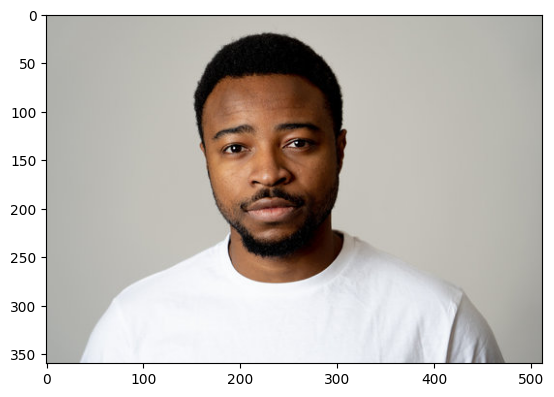

In [192]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [193]:
faceCascade = cv2.CascadeClassifier('xml version=1.0.xml')

In [194]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [195]:
gray.shape

(360, 512)

In [196]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for x, y, w, h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0),2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(faces)==0:
        print("Face not detected")
    else:
        for(ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]

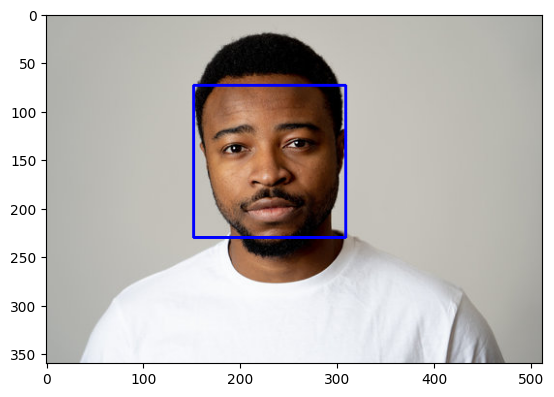

In [197]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [198]:
face_roi

array([[[ 13,  16,  20],
        [  6,   6,   6],
        [  4,   1,   0],
        ...,
        [  3,   0,   2],
        [  2,   0,   0],
        [  2,   0,   0]],

       [[ 13,  14,  18],
        [ 11,  11,  11],
        [  6,   3,   0],
        ...,
        [  3,   1,   1],
        [  4,   2,   1],
        [  2,   0,   0]],

       [[  9,  10,  14],
        [ 10,  10,  10],
        [  2,   2,   2],
        ...,
        [  3,   1,   1],
        [  2,   0,   0],
        [  4,   2,   1]],

       ...,

       [[187, 194, 197],
        [187, 194, 197],
        [187, 194, 197],
        ...,
        [187, 200, 202],
        [184, 192, 192],
        [185, 193, 193]],

       [[187, 194, 197],
        [187, 194, 197],
        [187, 194, 197],
        ...,
        [187, 200, 202],
        [186, 194, 194],
        [187, 195, 195]],

       [[187, 194, 197],
        [187, 194, 197],
        [187, 194, 197],
        ...,
        [185, 200, 203],
        [187, 195, 195],
        [187, 195, 195]]

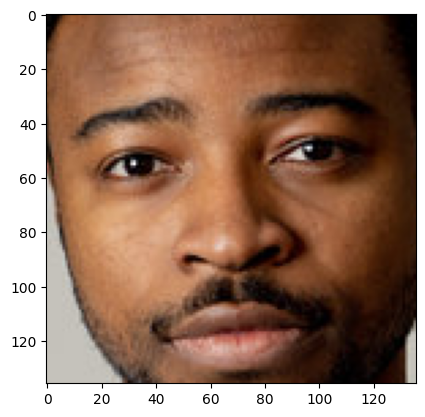

In [199]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [200]:
final_image = cv2.resize(face_roi, (224,224))
final_image = np.expand_dims(final_image, axis=0)  # need 4th dimension
final_image = final_image/255.0

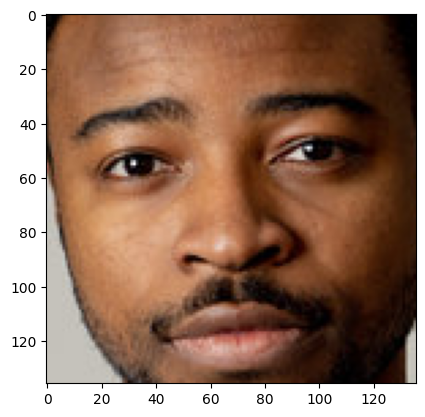

In [201]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [202]:
Predictions = new_model.predict(final_image)

1/1 [==============================] - 0s 41ms/step


In [203]:
Predictions[0]

array([4.6401748e-01, 4.9588367e-01, 4.0707152e-04, 3.9691836e-02],
      dtype=float32)

In [204]:
np.argmax(Predictions)

1

In [205]:
pred1 = cv2.imread("angry.jpg")

In [206]:
pred1.shape

(360, 518, 3)

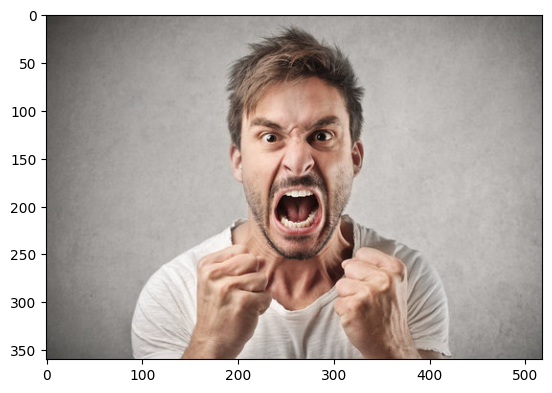

In [207]:
plt.imshow(cv2.cvtColor(pred1, cv2.COLOR_BGR2RGB))


In [208]:
gray1 = cv2.cvtColor(pred1, cv2.COLOR_BGR2GRAY)

In [209]:
gray1.shape

(360, 518)

In [210]:
faces1 = faceCascade.detectMultiScale(gray, 1.3, 5)
for x, y, w, h in faces1:
    roi_gray1 = gray1[y:y+h, x:x+w]
    roi_color1 = pred1[y:y+h, x:x+w]
    cv2.rectangle(pred1, (x,y), (x+w, y+h), (255, 0, 0),2)
    facess1 = faceCascade.detectMultiScale(roi_gray1)
    if len(faces1)==0:
        print("Face not detected")
    else:
        for(ex, ey, ew, eh) in facess1:
            face_roi1 = roi_color1[ey: ey+eh, ex:ex+ew]

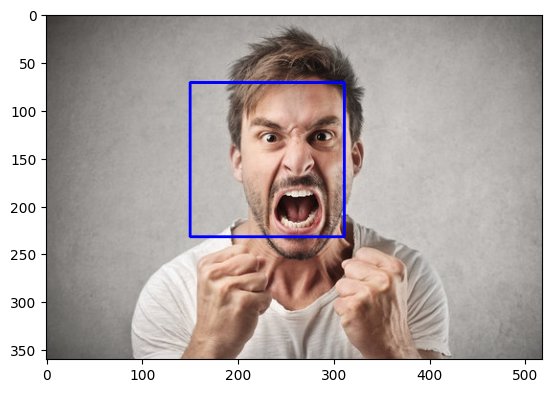

In [211]:
plt.imshow(cv2.cvtColor(pred1, cv2.COLOR_BGR2RGB))

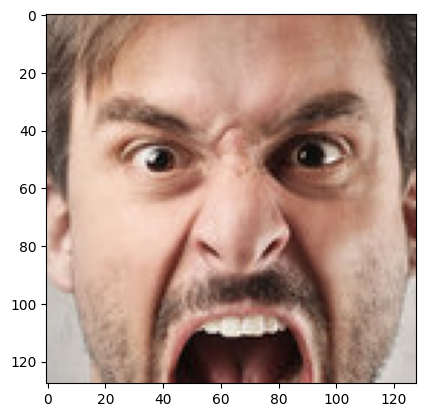

In [212]:
plt.imshow(cv2.cvtColor(face_roi1, cv2.COLOR_BGR2RGB))

In [213]:
final_image1 = cv2.resize(face_roi1, (224,224))
final_image1 = np.expand_dims(final_image1, axis=0)  # need 4th dimension
final_image1 = final_image1/255.0

In [214]:
Predictions1 = new_model.predict(final_image1)

1/1 [==============================] - 0s 37ms/step


In [215]:
Predictions1[0]

array([9.9999976e-01, 1.2911813e-08, 2.3669513e-07, 6.9978121e-09],
      dtype=float32)

In [216]:
np.argmax(Predictions1)

0

In [248]:
pred3 = cv2.imread("sad man.webp")

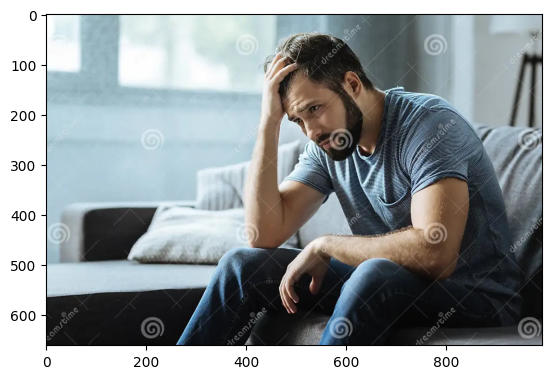

In [249]:
plt.imshow(cv2.cvtColor(pred3, cv2.COLOR_BGR2RGB))

In [250]:
gray3 = cv2.cvtColor(pred3, cv2.COLOR_BGR2RGB)

In [251]:
gray3.shape

(662, 992, 3)

In [257]:
faces3 = faceCascade.detectMultiScale(gray, 1.1, 4)
for x, y, w, h in faces3:
    roi_gray3 = gray3[y:y+h, x:x+w]
    roi_color3 = pred3[y:y+h, x:x+w]
    cv2.rectangle(pred3, (x,y), (x+w, y+h), (255, 0, 0),2)
    facess3 = faceCascade.detectMultiScale(roi_gray3)
    if len(faces3)==0:
        print("Face not detected")
    else:
        for(ex, ey, ew, eh) in facess3:
            face_roi3 = roi_color3[ey: ey+eh, ex:ex+ew]

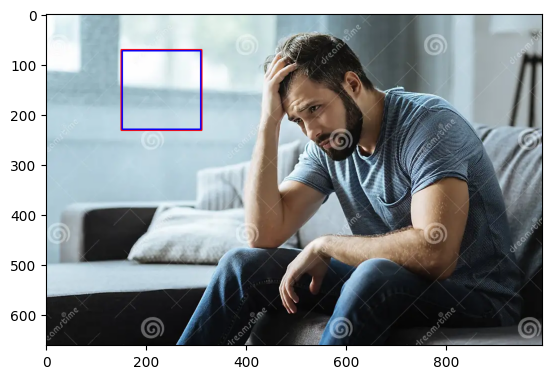

In [258]:
plt.imshow(cv2.cvtColor(pred3, cv2.COLOR_BGR2RGB))

In [107]:
# TF_LITE_MODEL_FILE_NAME = "tflite_new_model.tflite"
# tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
# tflite_model = tf_lite_converter.convert()
# tflite_model_name = TF_LITE_MODEL_FILE_NAME
# open(tflite_model_name, "wb").write(tflite_model)
# # convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the model
with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\dourr\AppData\Local\Temp\tmp35xokj2_\assets


INFO:tensorflow:Assets written to: C:\Users\dourr\AppData\Local\Temp\tmp35xokj2_\assets
